In [ ]:
# Global imports
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Step2: Extract the picture

✅ Cropped region saved as pic_4_crop.png
ROI used: (108, 667) → (1186, 894)
Output size: 1078x227


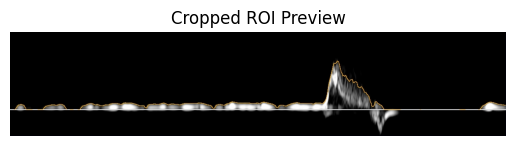

In [ ]:
ROOT_NAME = "pic_4"
in_path = Path(f"{ROOT_NAME}.jpg")      # input image filename
out_path = Path(f"{ROOT_NAME}_crop.png") # output file
ROI = {'x0': 108, 'y0': 667, 'x1': 1186, 'y1': 894}  # <— adjust here when needed
# ======================

if not in_path.exists():
    raise FileNotFoundError(f"Input image not found: {in_path}")

# Open and auto-rotate according to EXIF
img = Image.open(in_path)
img = ImageOps.exif_transpose(img)

# Clamp ROI to image bounds
w, h = img.size
x0 = max(0, min(ROI['x0'], w))
x1 = max(0, min(ROI['x1'], w))
y0 = max(0, min(ROI['y0'], h))
y1 = max(0, min(ROI['y1'], h))
if x1 <= x0 or y1 <= y0:
    raise ValueError(f"Invalid ROI after clamping: {ROI}")

# Crop and save
cropped = img.crop((x0, y0, x1, y1))
cropped.save(out_path, format="PNG")

print(f"✅ Cropped region saved as {out_path}")
print(f"ROI used: ({x0}, {y0}) → ({x1}, {y1})")
print(f"Output size: {cropped.size[0]}x{cropped.size[1]}")

plt.imshow(cropped)
plt.axis("off")
plt.title("Cropped ROI Preview")
plt.show()

# Step 3: Extract lines

✅ Extraction complete:
 - Combined lines:  pic_4_lines.png


C:\Users\Henry\AppData\Local\Temp\ipykernel_13800\2575484668.py:70: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(combined, "RGBA").save(OUT_COMBINED)


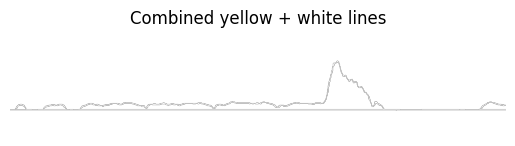

In [ ]:
# imports are in the first cell

# === CONFIG ===
IN_PATH = out_path        # your image
#OUT_YELLOW = Path("yellow_line.png")
#OUT_WHITE = Path("white_line.png")
OUT_COMBINED = Path(f"{ROOT_NAME}_lines.png")

# Color thresholds (HSV)
LOWER_YELLOW = (15, 80, 80)            # yellow/gold tone
UPPER_YELLOW = (45, 255, 255)
WHITE_THRESH = 180                     # brightness threshold
# ==============

# 1️⃣ Load image
bgr = cv2.imread(str(IN_PATH), cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"Could not read {IN_PATH}")
h, w = bgr.shape[:2]

# Convert color spaces
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# 2️⃣ Detect yellow waveform
mask_yellow = cv2.inRange(hsv, np.array(LOWER_YELLOW), np.array(UPPER_YELLOW))
mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

# 3️⃣ Detect white baseline
_, mask_white = cv2.threshold(gray, WHITE_THRESH, 255, cv2.THRESH_BINARY)
horizontal = cv2.morphologyEx(mask_white, cv2.MORPH_OPEN,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1)))
mask_white = cv2.bitwise_and(mask_white, horizontal)

# Keep the longest horizontal contour (the baseline)
contours, _ = cv2.findContours(mask_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    biggest = max(contours, key=cv2.contourArea)
    mask_white = np.zeros_like(mask_white)
    cv2.drawContours(mask_white, [biggest], -1, 255, thickness=cv2.FILLED)

# 4️⃣ Convert to RGBA layers
rgba_yellow = np.zeros((h, w, 4), dtype=np.uint8)
rgba_white = np.zeros((h, w, 4), dtype=np.uint8)

# Yellow: keep color where mask is set
idx_y = mask_yellow > 0
rgba_yellow[idx_y, :3] = bgr[idx_y][:, ::-1]  # BGR→RGB
rgba_yellow[idx_y, 3] = 255

# White line: pure white, opaque where mask is set
rgba_white[idx_y, :] = [255, 255, 255, 0]     # start clean
idx_w = mask_white > 0
rgba_white[idx_w, :3] = [255, 255, 255]
rgba_white[idx_w, 3] = 255

# 5️⃣ Combine both
combined = np.zeros_like(rgba_white)
combined[..., :3] = np.clip(
    rgba_yellow[..., :3].astype(np.uint16) + rgba_white[..., :3].astype(np.uint16), 0, 255
).astype(np.uint8)
combined[..., 3] = np.maximum(rgba_yellow[..., 3], rgba_white[..., 3])

# 6️⃣ Save results
#Image.fromarray(rgba_yellow, "RGBA").save(OUT_YELLOW)
#Image.fromarray(rgba_white, "RGBA").save(OUT_WHITE)
Image.fromarray(combined, "RGBA").save(OUT_COMBINED)

print("✅ Extraction complete:")
#print(f" - Yellow waveform: {OUT_YELLOW}")
#print(f" - White baseline:  {OUT_WHITE}")
print(f" - Combined lines:  {OUT_COMBINED}")

import matplotlib.pyplot as plt

plt.imshow(combined)
plt.axis("off")
plt.title("Combined yellow + white lines")
plt.show()


# Step 4: Convert to csv

In [ ]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd

# --- CONFIG ---
IMG_PATH = OUT_COMBINED  # white baseline + white waveform on transparent bg
DURATION_SEC = 6.0                     # total time span (seconds)
V_PEAK = 45.6                           # tallest peak (cm/s)
BASELINE_BAND = 3                      # pixels to remove above/below baseline
PERCENTILE_FOR_PEAK = 99.0             # robust peak percentile
# -------------

# 1) Load image (prefer RGBA so we can use alpha)
rgba = cv2.imread(str(IMG_PATH), cv2.IMREAD_UNCHANGED)
if rgba is None:
    raise FileNotFoundError(IMG_PATH)

h, w = rgba.shape[:2]

if rgba.shape[2] == 4:
    bgr = rgba[..., :3]
    alpha = rgba[..., 3]
    # Binary mask of where the lines exist (wave + baseline)
    mask_all = (alpha > 0).astype(np.uint8) * 255
else:
    bgr = rgba
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    # Fallback: threshold bright pixels (may need tuning if no alpha)
    mask_all = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]

# 2) Detect baseline row as the row with the most "on" pixels
row_counts = mask_all.sum(axis=1)  # count per row (0..255 sums)
y_base = int(np.argmax(row_counts))

# 3) Build waveform mask (remove a horizontal band around the baseline)
mask_wave = mask_all.copy()
y0 = max(0, y_base - BASELINE_BAND)
y1 = min(h, y_base + BASELINE_BAND + 1)
mask_wave[y0:y1, :] = 0  # remove baseline & its halo

# Optional cleanup: tiny gaps fill, small specks remove
mask_wave = cv2.morphologyEx(mask_wave, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)

# 4) For each column, find the first line pixel when scanning upward from the baseline
y_vals = np.full(w, np.nan, dtype=float)  # y index of waveform for each x
for x in range(w):
    col = mask_wave[:y_base, x]  # only above baseline
    # Scan downward (from y_base-1 up)
    ys = np.where(col > 0)[0]
    if ys.size:
        # pick the one closest to baseline: the largest y index
        y_vals[x] = ys.max()

# Pixel displacement above baseline (positive upward)
pix_disp = np.where(np.isfinite(y_vals), y_base - y_vals, np.nan)

# Sanity check: if still too flat, increase BASELINE_BAND or refine mask
valid = np.isfinite(pix_disp)
if not valid.any():
    raise RuntimeError("No waveform detected; adjust thresholds.")

# ▶ Re-zero the baseline using a small percentile (robust against outliers)
BASELINE_PERCENTILE = 1.0  # try 0.5–2.0 depending on your images
baseline_offset_pix = np.nanpercentile(pix_disp[valid], BASELINE_PERCENTILE)
# Remove baseline bias and clamp negatives
pix_disp = np.maximum(0.0, pix_disp - baseline_offset_pix)

# Continue as before with scaling
peak_pix = np.nanpercentile(pix_disp[valid], 99.0) or np.nanmax(pix_disp[valid])
px_per_cms = peak_pix / V_PEAK
velocity = pix_disp / (px_per_cms if px_per_cms != 0 else 1.0)

# Interpolate NaNs linearly, clamp negatives to 0
v = velocity.copy()
idx = np.where(np.isfinite(v))[0]
if idx.size >= 2:
    v_interp = v.copy()
    v_interp[:idx[0]] = v[idx[0]]
    v_interp[idx[-1] + 1:] = v[idx[-1]]
    for a, b in zip(idx[:-1], idx[1:]):
        if b - a > 1:
            m = (v[b] - v[a]) / (b - a)
            v_interp[a+1:b] = v[a] + m * (np.arange(a+1, b) - a)
    velocity = v_interp
velocity = np.where(velocity < 0, 0.0, velocity)

# 6) Time axis and CSV
time_s = (np.arange(w) / max(1, (w - 1))) * DURATION_SEC
df = pd.DataFrame({
    "x_px": np.arange(w, dtype=int),
    "y_px": y_vals,                 # y-index of the waveform
    "time_s": time_s,               # seconds
    "velocity_cm_s": velocity       # cm/s above baseline
})
out_csv = IMG_PATH.with_suffix(".csv")
df.to_csv(out_csv, index=False)
print(f"✅ Saved: {out_csv}  (rows={len(df)})")
print(f"Baseline row: {y_base}, px_per_cms: {px_per_cms:.4f}, peak_pix: {peak_pix:.2f}")




✅ Saved: pic_4_lines.csv  (rows=1078)
Baseline row: 170, px_per_cms: 2.1053, peak_pix: 96.00


# Step 5: Plotting the csv points

✅ Loaded pic_4_lines.csv with 1078 rows and columns: ['x_px', 'y_px', 'time_s', 'velocity_cm_s']


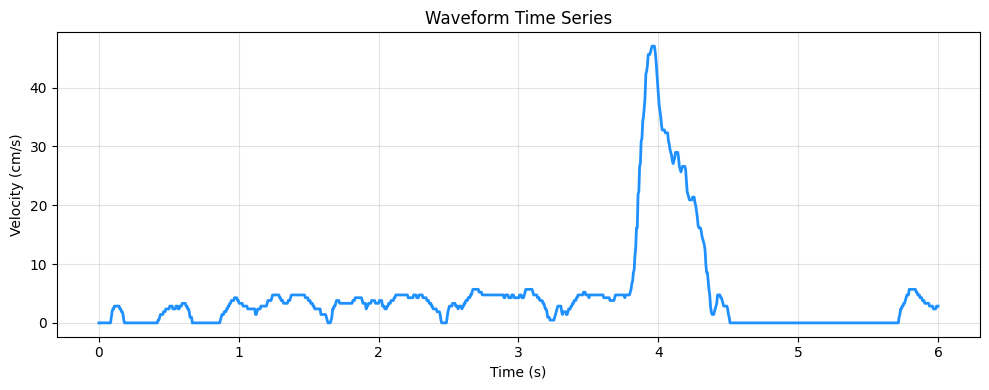

📊 Plot saved as C:\Users\Henry\Documents\MMS\Nelida\dus_pictures\pic_4_plot.png


In [ ]:
# imports are in the first cell

# === CONFIG ===
CSV_PATH = Path(out_csv)  # your CSV file
OUT_PLOT = Path(f"{ROOT_NAME}_plot.png")        # output image file
# ==============

# 1) Load CSV
df = pd.read_csv(CSV_PATH)
print(f"✅ Loaded {CSV_PATH} with {len(df)} rows and columns: {list(df.columns)}")

# 2) Determine what to plot
if {"time_s", "velocity_cm_s"}.issubset(df.columns):
    x = df["time_s"]
    y = df["velocity_cm_s"]
    xlabel, ylabel = "Time (s)", "Velocity (cm/s)"
elif len(df.columns) >= 2:
    # fallback: first two numeric columns
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) < 2:
        raise ValueError("No numeric columns to plot.")
    x, y = df[numeric_cols[0]], df[numeric_cols[1]]
    xlabel, ylabel = numeric_cols[0], numeric_cols[1]
else:
    raise ValueError("CSV missing numeric data to plot.")

# 3) Plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, color="dodgerblue", linewidth=2)
plt.title("Waveform Time Series")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=150)
plt.show()

print(f"📊 Plot saved as {OUT_PLOT.resolve()}")
